## **Multi Modal Self-Supervised Fusion**
**- Fine tuning the MMFusion model (ConvRNN_Model.pth)**

In [1]:
import numpy as np
import os 
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import torch
import tensorflow as tf
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sources import utils_spec, loss, models, MMFusion_Model
import matplotlib.pyplot as plt

### **A) Define the touchgesture model:**

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
touchModel = MMFusion_Model.TouchGestureModel(input_size=4, hidden_size=256, seq_length=1250, num_layers=2, batch_size=16, num_classes=100).to(device)

### **B) Define the spectrogram model:**

In [3]:
specModel = MMFusion_Model.SpectrogramModel(num_classes=100).to(device)

In [4]:
def testSpec(model, input):
    x = input.to(device)
    y0 = model(x)
    print("Output shape of spectrogram model: \n", y0.shape)
    print(y0)
    return y0

def testTouch(model, in_planes):
    x = torch.randn(16, in_planes, 1250)
    x = x.to(device)
    y0 = model(x)
    print("output shape of touch model: \n", y0.shape)
    print(y0)
    return y0

In [5]:
x_spec = torch.randn(16, 3, 65, 71)
y_spec = testSpec(specModel, input = x_spec)
y_touch = testTouch(touchModel, in_planes=4)

Output shape of spectrogram model: 
 torch.Size([16, 256])
tensor([[ 0.0440, -0.4741, -0.2110,  ..., -0.1336, -0.6886, -0.4825],
        [-0.6946, -0.0203,  0.6839,  ..., -0.5639,  0.1881, -0.8255],
        [ 0.0488, -0.2658, -0.3477,  ..., -0.3384, -0.4335, -1.2356],
        ...,
        [-0.6628, -0.0395, -0.2687,  ..., -0.1668, -0.1266, -0.5085],
        [-0.5367, -0.1633, -0.3225,  ..., -0.2500, -0.9152, -0.4351],
        [-0.1741,  0.1393, -0.7008,  ..., -0.3758, -0.3944, -0.2097]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
output shape of touch model: 
 torch.Size([16, 256])
tensor([[ 0.1224,  0.1956,  0.2850,  ...,  0.2926, -0.4099,  0.4273],
        [ 0.5265, -0.0533, -0.0638,  ..., -0.4958,  0.0815,  0.2965],
        [ 0.3575, -0.1108,  0.1402,  ..., -0.7650, -0.3673,  0.5431],
        ...,
        [ 0.2877,  0.3885,  0.6710,  ...,  0.1079, -0.1501,  0.5529],
        [ 0.4358, -0.4457,  0.3508,  ..., -0.4742,  0.4802,  0.1115],
        [ 0.0986, -0.1324,  0.3988,  ...,

In [6]:
Logs, touch_ds, y = utils_spec.dataGenerator(numUsers=1, pretraining=True, evaluation=False)

userID 0


100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


userID 1


100%|██████████| 13/13 [00:09<00:00,  1.39it/s]

(26, 10000, 3)
(26, 10000, 4)
(26,)


### Shape of Logs: (2, 10000, 3), because I have computed the norm for each sensor before loading them

In [7]:
numof_chunks = 8 # divide data on multu chunks (numof_chunks = 1 -> process the hole csv file)

Logs_2 = Logs.reshape(Logs.shape[0] * numof_chunks, Logs.shape[1]//numof_chunks, -1)

y_labels = []

for y0 in y:
    y_labels.append(np.zeros(numof_chunks) + y0)

y_labels = np.reshape(y_labels, -1)

print(Logs_2.shape)
print(y_labels.shape)

(208, 1250, 3)
(208,)


In [8]:
touch_logs = touch_ds.reshape(touch_ds.shape[0]*numof_chunks, touch_ds.shape[1]//numof_chunks, -1)
print(touch_logs.shape)

(208, 1250, 4)


In [9]:
x_spec = []
y_spec = []

#transpose data, fourier transform is applied on horizontal data
X = np.transpose(Logs_2, axes = [0, -1, 1])
print(X.shape)

for i, x in enumerate(tqdm(X)):
    x = abs(tf.signal.stft(x, 128, 16))
    x_spec.append(x)#, window_fn=window_fn))
    
x_spec = np.stack(x_spec)

#put the number of channels in the last axe to have the same data format supported by TensorFlow (9 channels) 
x_spec = np.transpose(x_spec, axes = [0, 3, 2, 1])
# config originale: [0, 3, 2, 1]

print(x_spec.shape)


(208, 3, 1250)


100%|██████████| 208/208 [00:01<00:00, 151.11it/s]

(208, 65, 71, 3)


In [10]:
sensorFusion = MMFusion_Model.fusionFFN(num_logits=256).to(device)
touchFusion = MMFusion_Model.fusionFFN(num_logits=256).to(device)

fusion_model = MMFusion_Model.pred_model(sensorModelPred=specModel, touchModelPred=touchModel, sensorFusionPred=sensorFusion, touchFusionPred=touchFusion,  fusion=True).to(device)

In [11]:
def test_fusion_pred():
    x1 = torch.randn(16, 3, 65, 71).to(device)
    x2 = torch.randn(16,4, 1250).to(device)
    y_i, y_j, y_fi, y_fj = fusion_model(x1, x2)
    return y_i, y_j, y_fi, y_fj

y0, y1, y2, y3 =test_fusion_pred()

In [12]:
print(y0.shape)
print(y1.shape)
print(y2.shape)
print(y3.shape)

torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16, 256])


In [13]:
x_train_sensor, x_test_sensor, y_train_sensor, y_test_sensor = train_test_split(x_spec, y_labels, test_size=0.2, shuffle=True, random_state=10)
x_train_touch, x_test_touch, y_train_touch, y_test_touch = train_test_split(touch_logs, y_labels, test_size=0.2, shuffle=True, random_state=10)

### **Dataset:**

In [14]:
class customDataset(Dataset):
    def __init__(self, sensorData, touchData, Y, transform=None):
        self.sensorData = np.array(sensorData)
        self.touchData = np.array(touchData)

        self.labels = np.array(Y)
        self.transform = transform

    def __getitem__(self, i):
        
        X_i = self.sensorData[i]
        X_j = self.touchData[i]

        X_i = self.transform(X_i)
        X_j = self.transform(X_j)

        y = self.labels[i]

        return (X_i, X_j, y)
    
    def __len__(self):
        return len(self.touchData)

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.ToTensor()])
train_set = customDataset(sensorData=x_train_sensor, touchData=x_train_touch, Y=y_train_sensor, transform=transform)
test_set = customDataset(sensorData=x_test_sensor, touchData=x_test_touch, Y=y_test_sensor,transform=transform)

In [16]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=16, drop_last=True)

##### **Display the data from train and test loaders**

In [17]:
for i ,(x1,x2, y)  in enumerate(train_loader):
    x1 = np.squeeze(x1, axis=1)
    x2 = np.squeeze(x2, axis=1)
    print("Train Sample: ", i)
    print("X1 shape:{}".format(x1.shape))
    print("X2 Shape:{}".format(x2.shape))
    print("Shape of labels:{}".format(y.shape))
    break

Train Sample:  0
X1 shape:torch.Size([16, 3, 65, 71])
X2 Shape:torch.Size([16, 1250, 4])
Shape of labels:torch.Size([16])


In [18]:
for i ,(x1,x2, y)  in enumerate(test_loader):
    x1 = np.squeeze(x1, axis=1)
    x2 = np.squeeze(x2, axis=1)
    print("Train Sample: ", i)
    print("X1 shape:{}".format(x1.shape))
    print("X2 Shape:{}".format(x2.shape))
    print("Shape of labels:{}".format(y.shape))
    break

Train Sample:  0
X1 shape:torch.Size([16, 3, 65, 71])
X2 Shape:torch.Size([16, 1250, 4])
Shape of labels:torch.Size([16])


In [19]:
if not os.path.isdir('finetuned_models/fusion'):
    os.mkdir('finetuned_models/fusion')
finetune_path = 'finetuned_models/fusion/'

def save_checkpoint(state, model='model'):

    filename = str(model) + '.pth'
    path_folder = os.path.join(finetune_path, filename)
    print("=>> Saving check_point...")
    torch.save(state, path_folder)

def finetune_loop(model, train_loader, test_loader, epochs, checkpoint='model'):
    train_history = {'train_loss':[], 'train_accuracy':[]}
    test_history = {'validation_loss':[], 'validation_accuracy':[]}

    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    #optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9,0.99), eps=1e-08, weight_decay=0)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    
    criterion = nn.BCELoss()
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        num_total = 0
        if epoch == epochs - 1:
            state = model.state_dict()
            save_checkpoint(state=state, model = checkpoint)
        for batch_idx, (x_i, x_j, y) in enumerate(train_loader):

            #labels = torch.tensor(y_train[:,0], dtype=torch.long)
            #labels = y[:,0].clone().detach()
            labels = y.clone().detach()
            x_i , x_j = x_i.to(device=device, dtype=torch.int64), x_j.to(device=device, dtype=torch.int64)
            train_labels = labels.to(device=device, dtype=torch.int64)

            x_i = x_i.float()
            x_j = x_j.float()

            #train_labels = (train_labels.squeeze(axis=1)).float()
            #train_labels = train_labels.float()
            
            train_labels = (train_labels).float()
            optimizer.zero_grad()
            
            
            outputs,_ = model(x_i, x_j)

            loss = criterion((outputs.squeeze(axis=1)).float(), train_labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

            #predictions = outputs.max(1) # replace it for sigmoid !!!

            predictions = (outputs > 0.5).long()

            num_total += predictions.size(0)

            #correct += predictions.eq(train_labels).sum().item()

            correct += (predictions == train_labels).sum()
            
        train_history['train_loss'].append(train_loss/num_total)
        train_history['train_accuracy'].append(float(correct)/float(num_total)*.100)
        
        model.eval()
        test_loss = 0
        correct = 0
        test_total = 0
        with torch.no_grad():
            for batch_idx, (x_i, x_j, y) in enumerate(test_loader):
                
                #test_labels = torch.tensor(y_test[:,0], dtype=torch.long)
                #test_labels = y[:,0].clone().detach()
                test_labels = y.clone().detach()
                
                x_i , x_j = x_i.to(device=device, dtype=torch.int64), x_j.to(device=device, dtype=torch.int64)
                test_labels = test_labels.to(device, dtype=torch.int64)

                x_i = x_i.float()
                x_j = x_j.float()

                #test_labels = (test_labels.squeeze(axis=1)).float()
                test_labels = (test_labels).float()
                
                outputs,_ = model(x_i, x_j)
                
                loss = criterion((outputs.squeeze(axis=1)).float(), test_labels)

                test_loss += loss.item()
                #_, predictions = outputs.max(1) # replace it for sigmoid !!!
                predictions = (outputs > 0.5).long()

                test_total += predictions.size(0)
                #correct += predictions.eq(test_labels).sum().item()
                correct += (predictions == test_labels).sum()
                
            test_history['validation_loss'].append(test_loss/test_total)
            test_history['validation_accuracy'].append(float(correct)/float(test_total)*.100)

            test_acc = 100.*correct/test_total
        
            print(
            "Epoch: ", epoch,
            "Correct: ", correct,
            "Loss: ", test_loss,
            "Accuracy: ", test_acc)
        
        #scheduler.step()
        
    return train_history, test_history

### **D) Define plot_values for plotting accuracy and loss curves:**

In [20]:
def plot_values(train_dict, test_dict):
    x_axis = range(0,len(train_dict["train_loss"]))

    fig, (ax1, ax2) = plt.subplots(1,2)
    #fig.subtitle('Accuracy and Loss')

    ax1.plot(x_axis, train_dict['train_loss'], '--', label='Training loss')
    ax1.plot(x_axis, test_dict['validation_loss'], '--', label='Validation loss', color='r')
    ax1.legend()
    #plt.ylabel('Loss function')
    ax1.grid()

    ax2.plot(x_axis, train_dict['train_accuracy'], '--', label='Train accuracy', color='r')
    ax2.plot(x_axis, test_dict['validation_accuracy'], '--', label='Validation accuracy', color='g')
    ax2.legend()
    ax2.grid()

    plt.show()

In [21]:
pretrain_path = 'pretrained_models/fusion/frequency_domain_models'

file_name = 'ConvRNN_Model_TF_Accelerometer' + '.pth'
path_folder = os.path.join(pretrain_path, file_name)
x = fusion_model.load_state_dict(torch.load(path_folder, map_location=device))

In [22]:
x

<All keys matched successfully>

In [23]:
ft_model = models.downstream_model.DSModel_Fusion(fusion_model, num_classes=1, fusion=True).to(device)

Epoch:  0 Correct:  tensor(346, device='cuda:0') Loss:  1.3724604845046997 Accuracy:  tensor(1081.2500, device='cuda:0')
Epoch:  1 Correct:  tensor(338, device='cuda:0') Loss:  1.3568350076675415 Accuracy:  tensor(1056.2500, device='cuda:0')
Epoch:  2 Correct:  tensor(330, device='cuda:0') Loss:  1.342733383178711 Accuracy:  tensor(1031.2500, device='cuda:0')
Epoch:  3 Correct:  tensor(322, device='cuda:0') Loss:  1.3296784162521362 Accuracy:  tensor(1006.2500, device='cuda:0')
Epoch:  4 Correct:  tensor(306, device='cuda:0') Loss:  1.3164609670639038 Accuracy:  tensor(956.2500, device='cuda:0')
Epoch:  5 Correct:  tensor(294, device='cuda:0') Loss:  1.2970944046974182 Accuracy:  tensor(918.7500, device='cuda:0')
Epoch:  6 Correct:  tensor(288, device='cuda:0') Loss:  1.278105914592743 Accuracy:  tensor(900., device='cuda:0')
Epoch:  7 Correct:  tensor(288, device='cuda:0') Loss:  1.2525380849838257 Accuracy:  tensor(900., device='cuda:0')
Epoch:  8 Correct:  tensor(288, device='cuda:0

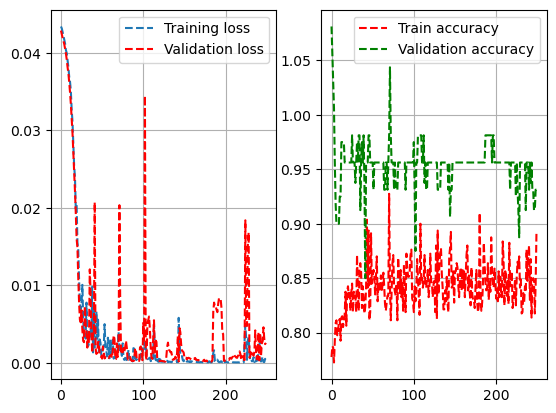

In [24]:
train_hist, test_hist = finetune_loop(ft_model, train_loader=train_loader, test_loader = test_loader, epochs=250,
                                      checkpoint='ConvRNN_finetuned_TF')
plot_values(train_dict=train_hist, test_dict=test_hist)